# Predict Complaint Types

The goal of this exercise is to do Model Development and Validation to find the answer to the Question 4 of the problem statement:

> Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

This exercise will be based on the findings of the previous three exercises. Therefore, we shall use the 311 complaints and the PLUTO data sets to feature-engineer a 'HEAT/HOT WATER' complaints for tax lots dataset. The latter is to be used to build a predictive model to estimate the number of future complaints based on selected house characteristics (which we will also refer to as properties or features).

We shall formalize the question at hand as follows:

> Build a prediction model for the number of 'HEAT/HOT WATER' complaints per year for a house with a selectd set of characteristics.

The rest of the work will be organized as follows, we shall:
1. Load, clean and prepare the data sets
   * In a similar way we did for answering Questions 1 to 3
2. Join the '311 complaint' data set with the PLUTO one
   * In a similar way we did for answering Questions 1 to 3
3. Determine the models to be used
   * This will influence the feature selection process
4. Perform house feature selection
   * This will be re-done as we used a different model for Question 3
5. Perform model training
   * Including parameter tuning and cross validation if any
6. Evaluate and compare models
7. Recommending the best performing model

Please note that, the data sets will not be described as the latter has already been done when answering Questions 1 to 3. We shall only repeat that the PLUTO data set will initially be taked with the following set of features:

In [1]:
pluto_features = ['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR',
              'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth',
              'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea',
              'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1',
              'ZipCode', 'YCoord', 'XCoord']
print('The initial set of PLUTO features to consider:\n', pluto_features)

The initial set of PLUTO features to consider:
 ['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1', 'ZipCode', 'YCoord', 'XCoord']


# 1. Load, clean, prepare

Loading of the data can be done both from the IBM cloud storage and the locally present CSV files. The latter is decided upon the presence of the proper secure field values of the credentials:

In [128]:
import os
import re
import seaborn
import ibm_boto3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from botocore.client import Config
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
# @hidden_cell
SECURITY_DUMMY = '----------------'
erm2_nwe9_creds = {
    'IAM_SERVICE_ID'    : SECURITY_DUMMY,
    'IBM_API_KEY_ID'    : SECURITY_DUMMY,
    'ENDPOINT'          : 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT' : 'https://iam.eu-gb.bluemix.net/oidc/token',
    'BUCKET'            : SECURITY_DUMMY,
    'FILE'              : 'erm2_nwe9.csv'
}
bk_18v1_creds = {
    'IAM_SERVICE_ID'    : SECURITY_DUMMY,
    'IBM_API_KEY_ID'    : SECURITY_DUMMY,
    'ENDPOINT'          : 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT' : 'https://iam.eu-gb.bluemix.net/oidc/token',
    'BUCKET'            : SECURITY_DUMMY,
    'FILE'              : 'BK_18v1.csv'
}
bx_18v1_creds = {
    'IAM_SERVICE_ID'    : SECURITY_DUMMY,
    'IBM_API_KEY_ID'    : SECURITY_DUMMY,
    'ENDPOINT'          : 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT' : 'https://iam.eu-gb.bluemix.net/oidc/token',
    'BUCKET'            : SECURITY_DUMMY,
    'FILE'              : 'BX_18v1.csv'
}
mn_18v1_creds = {
    'IAM_SERVICE_ID'    : SECURITY_DUMMY,
    'IBM_API_KEY_ID'    : SECURITY_DUMMY,
    'ENDPOINT'          : 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT' : 'https://iam.eu-gb.bluemix.net/oidc/token',
    'BUCKET'            : SECURITY_DUMMY,
    'FILE'              : 'MN_18v1.csv'
}
qn_18v1_creds = {
    'IAM_SERVICE_ID'    : SECURITY_DUMMY,
    'IBM_API_KEY_ID'    : SECURITY_DUMMY,
    'ENDPOINT'          : 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT' : 'https://iam.eu-gb.bluemix.net/oidc/token',
    'BUCKET'            : SECURITY_DUMMY,
    'FILE'              : 'QN_18v1.csv'
}
si_18v1_creds = {
    'IAM_SERVICE_ID'    : SECURITY_DUMMY,
    'IBM_API_KEY_ID'    : SECURITY_DUMMY,
    'ENDPOINT'          : 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT' : 'https://iam.eu-gb.bluemix.net/oidc/token',
    'BUCKET'            : SECURITY_DUMMY,
    'FILE'              : 'SI_18v1.csv'
}

pluto_creds = [bk_18v1_creds, bx_18v1_creds, mn_18v1_creds, qn_18v1_creds, si_18v1_creds]

In [4]:
# Allows to get the data source for the credentials from the IBM cloud or local csv file 
def get_data_source(credentials) :
    '''Creates a data source from the IBM cloud or local csv file according to the credentials'''
    # Here we check if the credentials are present, if not try 
    # load the local file if they are then read from the cloud.
    if credentials.get('IAM_SERVICE_ID') == SECURITY_DUMMY :
        # This is the alternative to get the code run locally with a local csv file
        body = 'data' + os.path.sep + credentials.get('FILE')
    else :
        client = ibm_boto3.client(
            service_name = 's3',
            ibm_api_key_id = credentials.get('IBM_API_KEY_ID'),
            ibm_auth_endpoint = credentials.get('IBM_AUTH_ENDPOINT'),
            config = Config(signature_version='oauth'),
            endpoint_url = credentials.get('ENDPOINT'))

        body = client.get_object(
            Bucket = credentials.get('BUCKET'),
            Key = credentials.get('FILE'))['Body']

        # add missing __iter__ method, so pandas accepts body as file-like object
        def __iter__(self): return 0
        if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

    return body

Further, we shall subsequently load the 311 and PLUTO data sets. Along the way, we will select the necessary columns and check on (, and correct if needed,) the column data types.

## 311 complaints

Balow we load the data set, and then first select the required complaints along with the needed columns:

In [5]:
# Get the data source for the credentials
dhp_ds = get_data_source(erm2_nwe9_creds)

# Read the CSV file
dhp_df = pd.read_csv(dhp_ds, parse_dates = ['created_date', 'closed_date'])
print('Number of all complaints:', dhp_df.shape[0])

Number of all complaints: 6034470


In [6]:
# Select the 'HEAT/HOT WATER' complaints
dhp_df = dhp_df[(dhp_df['complaint_type'] == 'HEAT/HOT WATER')]
print('Number of \'HEAT/HOT WATER\' complaints is:', dhp_df.shape[0])

Number of 'HEAT/HOT WATER' complaints is: 2159103


In [7]:
# Select the columns that matter, and rename for convenience
dhp_df = dhp_df[['created_date', 'incident_address', 'incident_zip']]
dhp_df = dhp_df.rename({'incident_address':'Address', 'incident_zip':'ZipCode'}, axis=1)

In [8]:
# Convert the address to upper case for uniformity
dhp_df.Address = dhp_df.Address.map(str).map(str.upper)
# Strip the address strings
dhp_df.Address = dhp_df.Address.str.strip()
# Replace sequence of white spaces with one
dhp_df.Address = dhp_df.Address.str.replace('\s+',' ')

In [9]:
# Drop the Na/NaN valued rows
init_size = dhp_df.shape[0]
dhp_df.dropna(inplace = True)
print('Number of rows before dropping Na/NaN:', init_size,', after:', dhp_df.shape[0])

Number of rows before dropping Na/NaN: 2159103 , after: 2140078


Exract the year the complaint was created and then drop the *'created_date'* column.

In [10]:
dhp_df['Year'] = dhp_df.created_date.dt.year
dhp_df.drop(columns = ['created_date'], inplace = True)

Let us summarize the Year statitics so far:

In [11]:
year_descr = dhp_df['Year'].describe().astype(int)
year_descr

count    2140078
mean        2014
std            2
min         2010
25%         2012
50%         2015
75%         2017
max         2020
Name: Year, dtype: int64

As one can see the min/max years range is between `2010` and `2020` which means that there were no missing/wrong *'created_date'* values present.

We will only need the average complaint counts per year for each given *'Address'*/*'ZipCode'* pair:

In [12]:
# Group by the zip code and address to count the complaints
dhp_df = dhp_df.groupby(['ZipCode', 'Address']).size().to_frame()

# Rename the counts column and then compute the average count for the min/max years range
dhp_df.rename({0 : 'AvgCnt'}, axis = 1, inplace = True)
dhp_df.AvgCnt = dhp_df.AvgCnt/(year_descr.loc['max'] - year_descr.loc['min'] + 1)

# Re-set the indexes to turn the Address and ZipCode back into columns
dhp_df.reset_index(level = 1, inplace = True)
dhp_df.reset_index(level = 0, inplace = True)
dhp_df.head()

,ZipCode,Address,AvgCnt
0,10001.0,10 WEST 28 STREET,1.454545
1,10001.0,100 WEST 26 STREET,0.090909
2,10001.0,102 WEST 29 STREET,0.727273
3,10001.0,103 WEST 27 STREET,0.181818
4,10001.0,11 WEST 34 STREET,0.090909


Finally, we check on the column types:

In [13]:
dhp_df.dtypes

ZipCode    float64
Address     object
AvgCnt     float64
dtype: object

All the data types are in order: the address is a string and the zip code and average complaint count are floats.

## PLUTO 

Let us load and combine all of the PLUTO csv files first:

In [14]:
# Iterate to load all the PLUTO csv files and
# re-combine them into a single data frame
pluto_df = pd.DataFrame()
for cred in pluto_creds :
    # Get the data source for the credentials
    ds = get_data_source(cred)
    # Read and append the CSV file
    pluto_df = pluto_df.append(pd.read_csv(ds, low_memory = False))

Perform initial pre-processing such as, selecting the right rows, dropping the Na/NaN valued rows, pre-processing the *'Address'* column values to match those of the '311 complaints' data set

In [15]:
num_pluto_rows = pluto_df.shape[0]

# Select the recommended columns
pluto_df = pluto_df[['Address', 'BldgArea', 'BldgDepth', 'BuiltFAR',
              'CommFAR', 'FacilFAR', 'Lot', 'LotArea', 'LotDepth',
              'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea',
              'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1',
              'ZipCode', 'YCoord', 'XCoord']]

# Drop the Na/NaN valued rows
pluto_df = pluto_df.dropna()

# Convert the address to upper case for uniformity
pluto_df.Address = pluto_df.Address.map(str).map(str.upper)
# Strip the address strings
pluto_df.Address = pluto_df.Address.str.strip()
# Replace sequence of white spaces with one
pluto_df.Address = pluto_df.Address.str.replace('\s+',' ')

print('The number of PLUTO rows before:', num_pluto_rows, ', after:', pluto_df.shape[0])

The number of PLUTO rows before: 859212 , after: 835242


As we know from aanswering Question 3, there are Address column values in the PLUTO data set that do not contain house numbers. As, before, let us drop entries those right away:

In [16]:
num_pluto_rows = pluto_df.shape[0]

# Create the pattern for selecting a proper address with one house
# number followed by a white space and then an alpha numeric street
# name which can contain multiple words separated by white spaces
regex_pat = re.compile(r'^\d+(\s+\w+)+')

# Then we only select the addresses that have a house number in it
pluto_df = pluto_df[pluto_df.Address.str.match(regex_pat)]

print('The number of PLUTO rows before:', num_pluto_rows, ', after:', pluto_df.shape[0])

The number of PLUTO rows before: 835242 , after: 522280


Next, the same as done for Question 3, we shall remove the entries with the duplicate *'Address'*/*'Zipcode'* pairs:

In [17]:
num_pluto_rows = pluto_df.shape[0]

# First count the distinct ZipCode-Address groups
occur_cnt = pluto_df.groupby(['ZipCode','Address']).size().to_frame()
occur_cnt.reset_index(level=0, inplace = True)
occur_cnt.reset_index(level=0, inplace = True)

# Rename the counts column
occur_cnt.rename(columns={0:'Count'}, inplace = True)

# Join the data into the original table
pluto_df_tmp = pd.merge(pluto_df, occur_cnt, left_on=['ZipCode','Address'], right_on=['ZipCode','Address'])

# Only keep the Address - ZipCode pairs that occur once
rows_index = pluto_df_tmp[pluto_df_tmp['Count'] > 1].index
pluto_df = pluto_df_tmp.drop(rows_index, axis = 0)

# Drop the counts columns is it will not be needed and remove the temporary object
pluto_df = pluto_df.drop('Count', axis = 1)
pluto_df_tmp = []

print('The number of PLUTO rows before:', num_pluto_rows, ', after:', pluto_df.shape[0])

The number of PLUTO rows before: 522280 , after: 520137


Finally, let us check on the column data types, as we see there is no unexpected types here:

In [18]:
pluto_df.dtypes

Address        object
BldgArea        int64
BldgDepth     float64
BuiltFAR      float64
CommFAR       float64
FacilFAR      float64
Lot             int64
LotArea         int64
LotDepth      float64
NumBldgs        int64
NumFloors     float64
OfficeArea      int64
ResArea         int64
ResidFAR      float64
RetailArea      int64
YearBuilt       int64
YearAlter1      int64
ZipCode       float64
YCoord        float64
XCoord        float64
dtype: object

# 2. Join data sets

In this section we shall join the cleaned 311 and PLUTO data sets to form a single data frame, we shall do it by performing an inner joint on the 311 and PLUTO data frames. The goint will be done by *'Address'* and *'ZipCode'* columns. This way we will only get the complaints that are marched with the PLUTO tax lot. This approach solves the three yet unresolved issues with the PLUTO data set mentioned in the previous section by ignoring the complaints that could not be matched with the tax lots because of the missing house numbers.

In [352]:
num_311_rows = dhp_df.shape[0]

dhp_pluto_df = pd.merge(dhp_df, pluto_df, how='inner', left_on=['ZipCode','Address'], right_on=['ZipCode','Address'])

print('The number of 311 rows before:', num_311_rows, ', after:', dhp_pluto_df.shape[0])

The number of 311 rows before: 126902 , after: 82937


As one can see the inner joint has reduced our data quite significantly, i.e. by about `100 - (82937 * 100) / 126902 = 34.64`%. However, this is the price we have to pay unless we do a more thorough pre-porocessing of the PLUTO data set. 

Please note that, the number of house properties (features) that is selected is currently rather large:

In [353]:
NUM_FEATURES = (dhp_pluto_df.shape[1] - len(['Lot', 'Address', 'ZipCode', 'AvgCnt']))
print('The number of selected features is:', NUM_FEATURES)

The number of selected features is: 17


We do not consider *'Lot'*, *'Address'*, *'ZipCode'*, and *'AvgCnt'* as the former two were used to join the 311 and PLUTO data sets and are not directly related to house properties. The latter is the target variable, i.e. the one that shall depend on the house properties.

It does not seem that the *'Lot'*, *'Address'* and *'ZipCode'* columns will be needed so let us drop them:

In [354]:
dhp_pluto_df.drop(columns = ['Lot', 'Address', 'ZipCode'], inplace = True)
display(dhp_pluto_df.head())

,AvgCnt,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,YCoord,XCoord
0,1.454545,9763,98.0,3.95,10.0,10.0,2469,98.75,1,5.0,0,4875,0.0,4888,1930,1979,210644.0,987501.0
1,0.727273,8970,82.0,4.16,10.0,10.0,2156,98.75,1,5.0,0,0,10.0,1790,1920,1989,211297.0,986855.0
2,0.181818,4796,76.0,2.88,10.0,10.0,1668,83.42,1,4.0,0,3276,10.0,1520,1920,1989,210983.0,986664.0
3,0.090909,17153,120.0,5.42,15.0,15.0,3162,126.50,1,6.0,1877,0,10.0,7765,1920,0,212224.0,988263.0
4,0.545455,20422,96.0,4.83,10.0,10.0,4229,98.75,2,7.0,0,12866,0.0,4834,1920,2005,211262.0,986709.0


Finally, let us double-check that there are no Na/NaN values present in the resulting joint data frame:

In [355]:
dhp_pluto_df.isna().describe()

,AvgCnt,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,YCoord,XCoord
count,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937,82937


According to the table above there are no Na/NaN values present so we can proceed with building models to predict the number of 'HEAT/HOT WATER' comlaints per year based on house properties.

Let us now notice that the values for the numer of floors do not seem to be well alligned:

In [356]:
dhp_pluto_df.NumFloors.unique()

array([ 5.  ,  4.  ,  6.  ,  7.  , 39.  , 11.  , 13.  , 12.  , 10.  ,
       26.  ,  3.  ,  9.  , 18.  , 16.  , 21.  , 17.  ,  0.  , 14.  ,
       15.  , 22.  ,  1.  ,  8.  , 23.  , 33.  ,  4.5 , 34.  , 41.  ,
       20.  ,  2.  , 42.  , 48.  , 19.  ,  2.5 ,  3.5 , 27.  , 32.  ,
       25.  , 24.  , 31.  , 50.  , 38.  , 45.  , 29.  , 47.  , 37.  ,
       66.  , 36.  , 54.  , 56.  , 58.  , 44.  ,  6.5 ,  5.5 , 13.5 ,
       60.  , 11.5 ,  4.75, 30.  ,  7.5 , 20.5 , 52.  , 28.  , 35.  ,
       57.  , 43.  , 23.5 , 78.  , 62.  , 40.  , 49.  , 35.5 , 18.5 ,
        9.5 , 51.  , 22.5 , 15.5 ,  3.75, 16.5 , 12.5 ,  5.09, 14.5 ,
       10.5 ,  2.75,  1.5 , 59.  , 46.  , 76.  ,  1.67,  1.75,  2.67,
        2.25,  3.33,  4.25,  4.33,  3.25,  6.25,  1.25])

Let us round the values up to 0.5:

In [357]:
def round_0_5(x):
    return np.around(x / 0.5, decimals = 0)*0.5
    
dhp_pluto_df.NumFloors = dhp_pluto_df.NumFloors.apply(round_0_5)

Now use the Z-Score to remove the outliers for all the rows.

In [358]:
# Only keep the values within the 3 standard deviations from the mean
num_joint_rows = dhp_pluto_df.shape[0]
dhp_pluto_df = dhp_pluto_df[(np.abs(stats.zscore(dhp_pluto_df)) <= 3).all(axis=1)]
print('The number of rows before:', num_joint_rows, ', after:', dhp_pluto_df.shape[0])

The number of rows before: 82937 , after: 74363


We use the 3 standard deviations filter for the outliers, and the data set size gets reduced by `100 - (74363 * 100) / 82937 = 10.33`%. Let us now notice that the number of unique complaint counts is quite large whereas the complaint counts range is not:

In [359]:
print('The bumber of unique complaint counts is:', len(dhp_pluto_df.AvgCnt.unique()))
dhp_pluto_df.AvgCnt.describe()

The bumber of unique complaint counts is: 285


count    74363.000000
mean         1.363953
std          2.954517
min          0.090909
25%          0.090909
50%          0.272727
75%          1.090909
max         26.000000
Name: AvgCnt, dtype: float64

At the moment there is two possible ways to proceed, i.e. to consider the average number of complaint per year as:

1. A continuus value which is subject to a regression model
2. A a discrete value which is a subject to a classification model

Let us further analyze the data at hand in the next section where we will work on selecting the right model and model features.

# 4. Model and feature selection

Before we go into the feature selection let us see the data types of the columns at hand:

In [317]:
dhp_pluto_df.dtypes

AvgCnt        float64
BldgArea        int64
BldgDepth     float64
BuiltFAR      float64
CommFAR       float64
FacilFAR      float64
LotArea         int64
LotDepth      float64
NumBldgs        int64
NumFloors     float64
OfficeArea      int64
ResArea         int64
ResidFAR      float64
RetailArea      int64
YearBuilt       int64
YearAlter1      int64
YCoord        float64
XCoord        float64
dtype: object

All columns have numeric values, both the predictor and the target variable columns. In order to improve the analysis we should scale the data, for this we can use the `StandardScaler` from the `sklearn.preprocessing` package.

Ley us take the predictor (`X`) columns, and transform them into a scaled NumPy matrix:

In [318]:
# Scale the predictor (X) columns
scaler = StandardScaler()
X = dhp_pluto_df.iloc[:,0:NUM_FEATURES].values.astype(float)
X = scaler.fit(X).transform(X)
display(X)
print('Shape:', X.shape)

# Store the feature names in an array
FEATURE_NAMES = dhp_pluto_df.columns[range(1, NUM_FEATURES + 1)]
print('The considered featues are:', FEATURE_NAMES)

array([[-0.40011364,  2.92081278,  0.89643121, ...,  0.33691753,
        -0.52401163,  0.21623591],
       [ 4.73843107,  0.03323009,  1.95984344, ..., -0.16620552,
         1.90026667,  0.21149769],
       [ 3.44610246,  0.01782023,  1.95984344, ..., -0.16620552,
         1.90026667,  0.21185756],
       ...,
       [-0.18472554, -0.49468353, -0.69868712, ...,  0.7322285 ,
        -0.52401163, -1.58071826],
       [-0.27703473, -0.41354364,  1.11797543, ...,  0.04941864,
        -0.52401163, -1.60539898],
       [-0.40011364, -0.45310494, -0.87592249, ...,  0.01348128,
        -0.52401163, -1.58389706]])

Shape: (74363, 17)
The considered featues are: Index(['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'LotArea',
       'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea',
       'ResidFAR', 'RetailArea', 'YearBuilt', 'YearAlter1', 'YCoord',
       'XCoord'],
      dtype='object')


Next, let us extract the target variable (`AvgCnt`) column:

In [319]:
# Get the target (Y) column
y = dhp_pluto_df.loc[:,'AvgCnt'].values
print('y shape', y.shape )

y shape (74363,)


## 4.1 Recursive feature elimination

In [320]:
# Total number of features
nof_list = np.arange(1,NUM_FEATURES)            
high_score=0

#Variable to store the optimum features
nof = 0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model, nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score > high_score):
        high_score = score
        nof = nof_list[n]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 1
Score with 1 features: 1.000000


In [321]:
cols = list(FEATURE_NAMES)
#Initializing RFE model
model = LinearRegression()
#Transforming data using RFE
rfe = RFE(model, 1)
#Fitting the data to model
X_rfe = rfe.fit_transform(X,y)
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['BldgArea'], dtype='object')


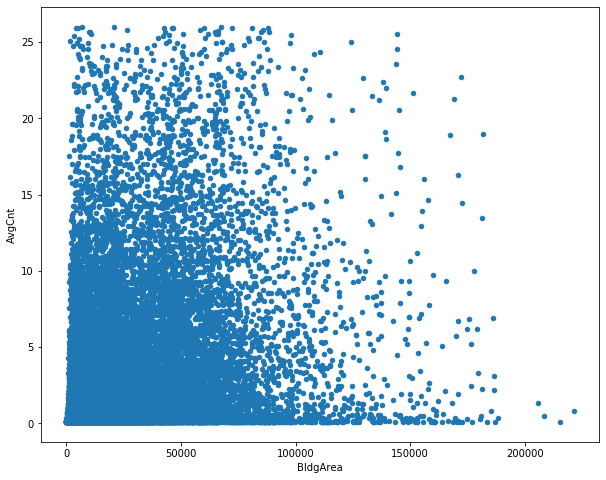

In [322]:
dhp_pluto_df[['BldgArea','AvgCnt']].plot(kind='scatter', x = 'BldgArea', y = 'AvgCnt', figsize = (10,8))

## 4.1 Univariate Selection

Here we shall consider the `SelectKBest` and `f_regression` from the `sklearn.feature_selection` package.
We prefer `f_regression` here over other classifiers because it relies on computation of feature probability distribution which is usually done by using non-parametric methods without any major assumptions.

Let us now compute the top 5 scoring features:

In [278]:
# Create the selector
selector = SelectKBest(f_regression, k = 'all')
# Train on the train set
selector.fit(X, y)

SelectKBest(k='all', score_func=<function f_regression at 0x127726af0>)

In [279]:
# Create the score results data frame 
us_scores_df = pd.DataFrame({ 'feature' : FEATURE_NAMES,
                              'score'   : selector.scores_,
                              'pvalue' : selector.pvalues_})
us_scores_df = us_scores_df.set_index('feature')
us_scores_df.sort_values(by = 'score', ascending = False, inplace = True)
display(us_scores_df.head())

,score,pvalue
feature,,
BldgArea,3.705005e+17,0.0
ResidFAR,1.799777e+04,0.0
BldgDepth,1.474948e+04,0.0
BuiltFAR,1.008010e+04,0.0
CommFAR,9.988566e+03,0.0


 Let us also plot the score values, mind the logarithmic scale:

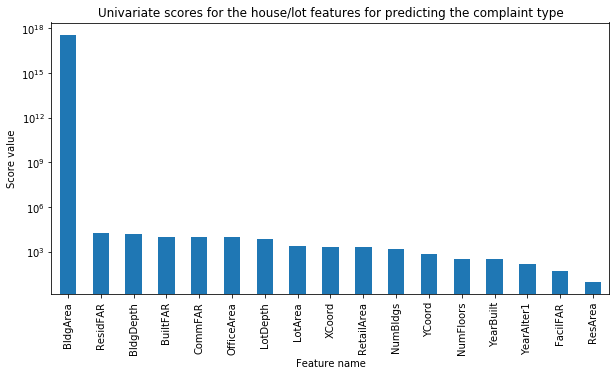

In [280]:
us_scores_df['score'].plot(kind='bar', figsize=(10,5), logy = True)
plt.title('Univariate scores for the house/lot features for predicting the complaint type')
plt.ylabel('Score value')
plt.xlabel('Feature name')
plt.show()
plt.close()

 Let us also plot the score p-values, mind the logarithmic scale:

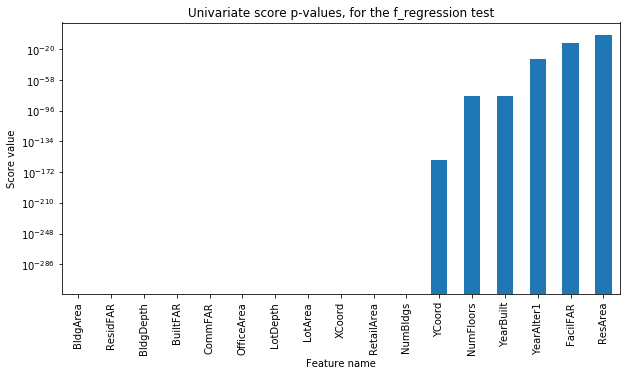

In [281]:
us_scores_df['pvalue'].plot(kind='bar', figsize=(10,5), logy = True)
plt.title('Univariate score p-values, for the f_regression test')
plt.ylabel('Score value')
plt.xlabel('Feature name')
plt.show()
plt.close()

As one can see all the p-values are way below `0.01` so the scores are significant, the top 5 scoring features are:

In [283]:
us_top_5 = us_scores_df.index[0:5].to_list()
display(us_top_5)

['BldgArea', 'ResidFAR', 'BldgDepth', 'BuiltFAR', 'CommFAR']

## 4.3 Feature correlations

Correlation states how the features are related to each other and/or the target variable. Since we have already removed the outliers, we can use the Perason correlation. Further, we build the correlation matrix and visualize it user a heatmap:

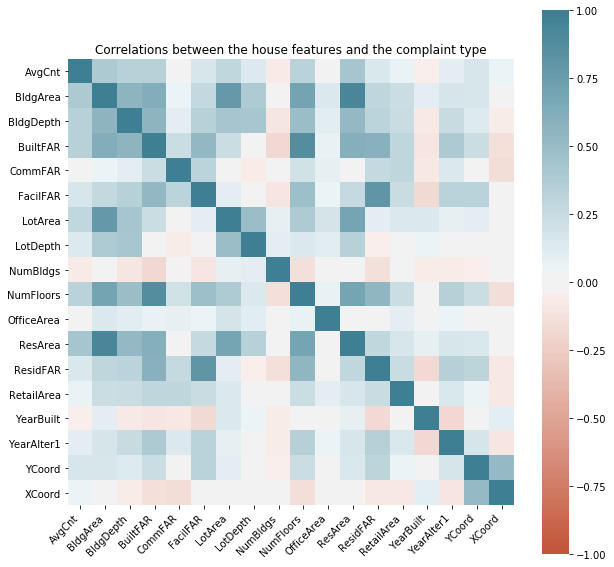

In [284]:
dhp_pluto_corr_df = dhp_pluto_df.corr(method='pearson')

plt.figure(figsize=(10,10))
plt.title('Correlations between the house features and the complaint type')
ax = sns.heatmap(
    dhp_pluto_corr_df, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

As one can see there is a number of strongly positively and negatively correlated features. This means that if we are to build a prediction model for the complain type the number of features to be used is likely to be significantly reducible. The correlation values for the *'AvgCnt'* with respect to the features are as follows:

In [285]:
display(dhp_pluto_corr_df['AvgCnt'].sort_values(ascending = False))

AvgCnt        1.000000
ResArea       0.430075
BldgArea      0.396001
BldgDepth     0.335813
BuiltFAR      0.334456
NumFloors     0.327113
LotArea       0.287433
FacilFAR      0.166174
YCoord        0.164489
ResidFAR      0.155138
LotDepth      0.136062
YearAlter1    0.094656
RetailArea    0.066238
XCoord        0.049062
OfficeArea   -0.010845
CommFAR      -0.025156
YearBuilt    -0.042460
NumBldgs     -0.066252
Name: AvgCnt, dtype: float64

Let us compute the absolute correlation values for features and the *'AvgCnt'*:

In [286]:
NUM_COLS = dhp_pluto_corr_df.shape[1]
corr_scores_df = dhp_pluto_corr_df['AvgCnt'].abs().sort_values(ascending=False)[1:NUM_COLS].to_frame()
corr_scores_df.rename({'AvgCode' : 'abs_corr'}, axis = 1, inplace = True)
corr_scores_df.head()

,AvgCnt
ResArea,0.430075
BldgArea,0.396001
BldgDepth,0.335813
BuiltFAR,0.334456
NumFloors,0.327113


The top 5 correlated features with the target variable are:

In [287]:
corr_top_5 = corr_scores_df.index[0:5].to_list()
corr_top_5

['ResArea', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'NumFloors']

KeyboardInterrupt: 

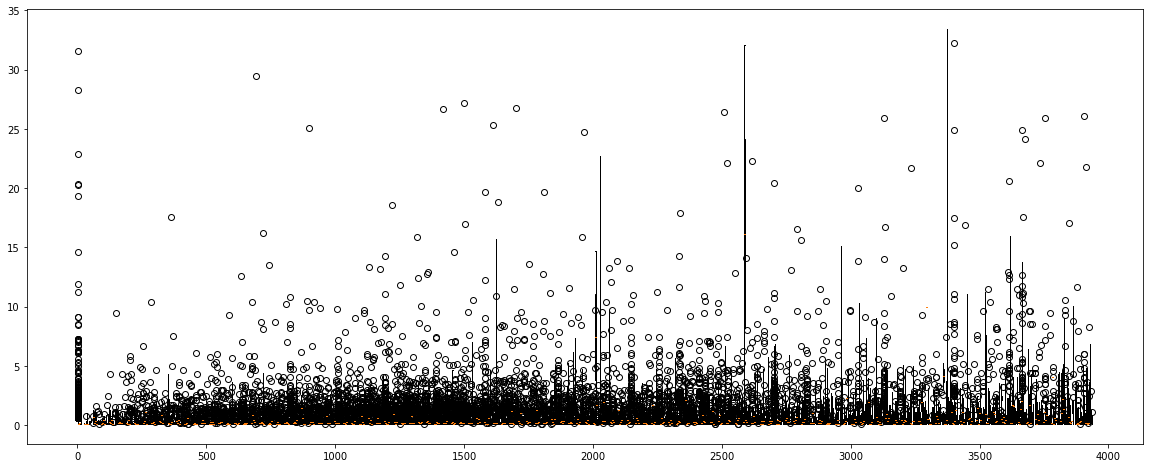

In [308]:
res_area_df = pd.pivot(dhp_pluto_df, columns = 'ResArea', values = 'AvgCnt')
res_area_df.plot(kind='box', figsize = (20,8))

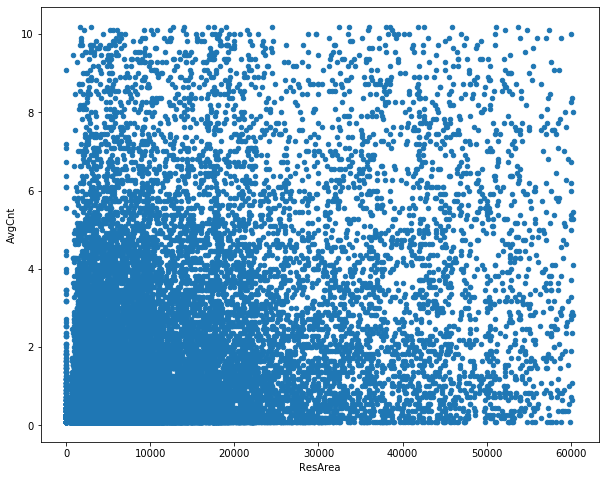

In [244]:
dhp_pluto_df.plot(kind='scatter', x = 'ResArea', y = 'AvgCnt', figsize = (10,8))

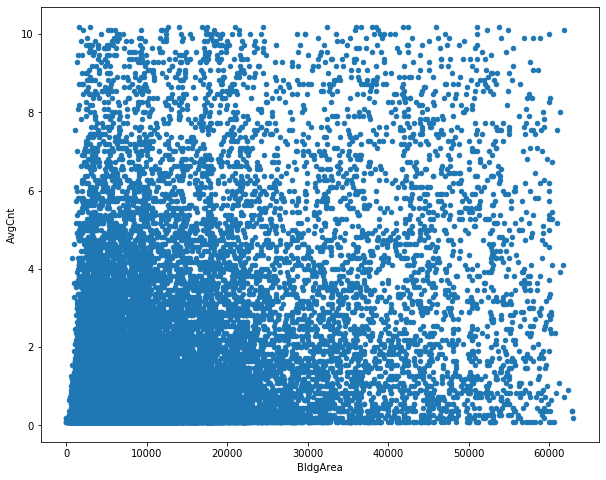

In [245]:
dhp_pluto_df.plot(kind='scatter', x = 'BldgArea', y = 'AvgCnt', figsize = (10,8))

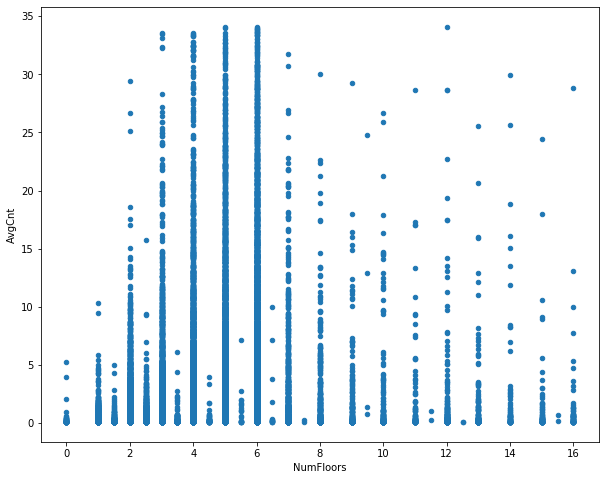

In [302]:
dhp_pluto_df.plot(kind = 'scatter', x = 'NumFloors', y = 'AvgCnt', figsize = (10,8))

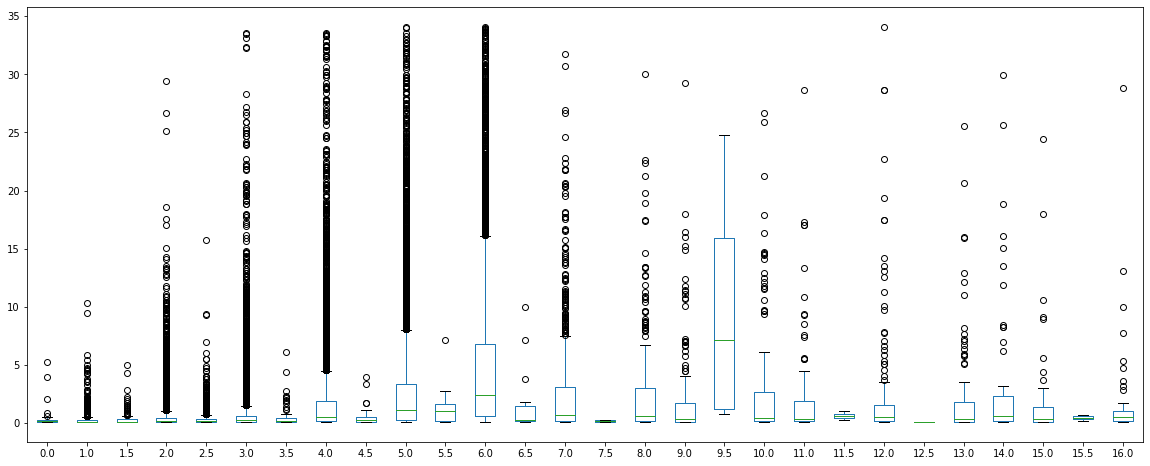

In [303]:
floors_df = pd.pivot(dhp_pluto_df, columns = 'NumFloors', values = 'AvgCnt')
floors_df.plot(kind='box', figsize = (20,8))

NumFloors
0.0     0.417832
1.0     0.310810
1.5     0.326729
2.0     0.451122
2.5     0.392724
3.0     0.695976
3.5     0.463925
4.0     1.869700
4.5     0.518595
5.0     2.926540
5.5     1.207792
6.0     5.012102
6.5     1.766234
7.0     2.720947
7.5     0.181818
8.0     2.516481
9.0     1.982074
9.5     9.977273
10.0    2.873222
11.0    2.386119
11.5    0.636364
12.0    2.471658
12.5    0.090909
13.0    2.000000
14.0    2.926290
15.0    1.739899
15.5    0.454545
16.0    1.590909
dtype: float64

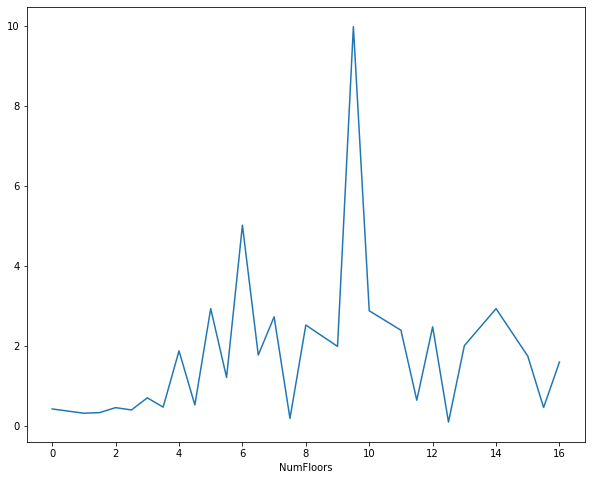

In [307]:
floors_df.mean().plot(figsize = (10,8))
floors_df.mean()

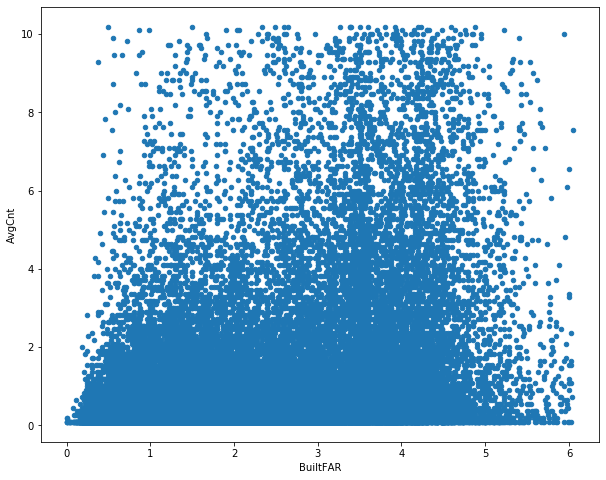

In [250]:
dhp_pluto_df.plot(kind='scatter', x = 'BuiltFAR', y = 'AvgCnt', figsize = (10,8))

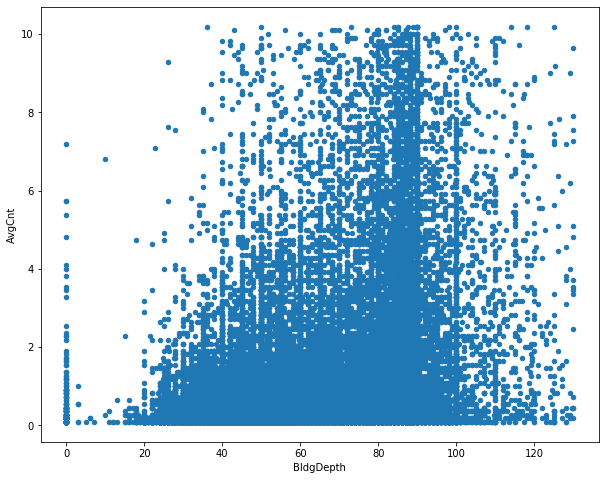

In [251]:
dhp_pluto_df.plot(kind='scatter', x = 'BldgDepth', y = 'AvgCnt', figsize = (10,8))

## 4.4 Final selection

# 5. Split the data

# 6. Train models

# 7. Evaluate models

## 7.1 Model 1

## 7.2 Model 2

## 7.3 Evaluation summary

# 8. Conclusions

In [254]:
help(dhp_pluto_df.corr)

Help on method corr in module pandas.core.frame:

corr(method='pearson', min_periods=1) -> 'DataFrame' method of pandas.core.frame.DataFrame instance
    Compute pairwise correlation of columns, excluding NA/null values.
    
    Parameters
    ----------
    method : {'pearson', 'kendall', 'spearman'} or callable
        Method of correlation:
    
        * pearson : standard correlation coefficient
        * kendall : Kendall Tau correlation coefficient
        * spearman : Spearman rank correlation
        * callable: callable with input two 1d ndarrays
            and returning a float. Note that the returned matrix from corr
            will have 1 along the diagonals and will be symmetric
            regardless of the callable's behavior.
    
            .. versionadded:: 0.24.0
    
    min_periods : int, optional
        Minimum number of observations required per pair of columns
        to have a valid result. Currently only available for Pearson
        and Spearman correla